## This code creates control variates based on polynomials of order 1 or 2  using Pytorch

sources:
https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

https://github.com/init27Lab/DL-Toolkit/blob/master/PyTorch/Linear%20Regression.ipynb

In [2]:
import sys
sys.path.append('/home/eym16/anaconda3/lib/python3.6/site-packages')

import torch
import torch.nn as nn 
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import bisect
import pandas as pd
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

## Data generation

In [3]:
#Choice of the mean of the multivariate normal distribution
mean1 = np.array([0])
#Choice of the variance of the multivariate normal distribution
cov1 = np.array([[1]])
np.random.seed(123)
x_training= np.random.multivariate_normal(mean1, cov1, 50) #2d-array of type float64
d = len(x_training[0])#dimension of the space on which we integrate
x_training = np.asarray(x_training,dtype=np.float32).reshape(-1,d)#2d-array of type float32

###Functions we want to integrate
#h1 returns a [len(x) \times 1] 2d-array such that h1(x)=\sum_{i=1}^{n} x_i
def h1(x):#x is a 2d-array
    return(x.dot(np.ones((len(x[0]), 1))))

#sphere function  returns a [len(x) x 1] 2d-array such; h2(x)=\sum_{i=1}^{d} x_i^2 where d is the dimension of the integration space
def h2(x):#x is a 2d-array
    return (x**2).dot(np.ones((len(x[0]), 1)))

#h3 returns a [len(x) x 1] 2d-array such that h3(x)=\sum_{i=1}^{n} x_i^3
def h3(x):#x is a 2d-array
    return (x**3).dot(np.ones((len(x[0]), 1)))

y_training = h3(x_training)#true value of y
y_training= np.asarray(y_training,dtype=np.float32).reshape(-1,1)#2d-array of type float32

## Definition of the model

In [4]:
#Linear model with one linear hidden layer
class LinearPolynomialModel(nn.Module):
    def __init__(self,bias):
        super(LinearPolynomialModel, self).__init__()
        self.linear = nn.Linear(d, 1, bias=bias)       
        
    def forward(self, x):
        out = self.linear(x)
        return out
#Linear a quadratic with one linear hidden layer and one one bilinear hidden layer
class QuadraticPolynomialModel(nn.Module):
    def __init__(self,bias):
        super(QuadraticPolynomialModel, self).__init__()
        self.linear = nn.Linear(d, 1, bias=False)  
        self.quadratic = nn.Bilinear(d, d, 1, bias=bias)       
        
    def forward(self, x):
        out = self.quadratic(x,x)+self.linear(x)
        return out

#Crreation if an instance of the class    
#model = LinearPolynomialModel(bias=False)#model without bias
model = QuadraticPolynomialModel(bias=False)#model without bias

## Loss function and optimizer

In [5]:
## returns the gradient of a multivariate normal distribution; returns a 2d-array of size (d, len(x))
#x is a 1d-tensor of size 
def NablaLogPdf(x):
    #convert cov into a 2d-tensor
    cov = torch.from_numpy(np.asarray(cov1,dtype=np.float32).reshape(d,d))
    #convert mean into a 2d-tensor
    mean = torch.from_numpy(np.asarray(mean1,dtype=np.float32).reshape(d,1))
    #convert the 1d input tensor into a 2d-tensor
    x = x.view(d, -1)
    return (- torch.mm(torch.inverse(cov), torch.add(x, - mean)))#return -x in dim 1


#only works in the case on 1st order polynomials; for a "y=c^{t}x" model
#x is a 1d-tensor; parameters is a tensor of size ([1, d]) that is the weights
#def stein_operator(x, params):
#    temp = NablaLogPdf(x)
#    return torch.mm(params[0], temp) #params[0] contains the weights

#only works in the case on 2nd order polynomials; for a "y(x)=c^{t}x + x^{t}Bx" model
#x is a 1d-tensor; parameters is a tensor of size ([1, d]) that is the weights
def stein_operator(x, params):#uses the second order operator
    temp = NablaLogPdf(x)
    #convert the 1d input tensor into a 2d-tensor
    x = x.view(d, -1)
    B= params[1].view(d, d)#value of B
    Bt = torch.t(B)#values of B^T
    BaddBt = torch.add(B, Bt)#value of B + B^T
    nabla= params[0].view(d, -1) + torch.mm(BaddBt, x)#gradient of y(x)
    laplacian = torch.trace(BaddBt)#laplacian of y(x)
    return ( torch.mm(torch.t(nabla), temp) + laplacian)

#loss function
class VarianceLoss(torch.nn.Module):

    def __init__(self):
        super(VarianceLoss,self).__init__()   

    def forward(self,x,y, parameters):
        n = x.size()[0]
        out = 0.
        for i in range(n):
            for j in range(n):
                out += (y[i]-stein_operator(x[i], parameters)-y[j]+stein_operator(x[j], parameters))**2
        out *= 1./(n*(n-1))     
        return out
    
criterion = VarianceLoss()

l_rate = 0.01
optimiser = torch.optim.SGD(model.parameters(), lr = l_rate) #Stochastic Gradient Descent

## Training

[Parameter containing:
tensor([[-0.5765]]), Parameter containing:
tensor([[[ 0.8010]]])]
initial state
OrderedDict([('linear.weight', tensor([[-0.5765]])), ('quadratic.weight', tensor([[[ 0.8010]]]))])
epoch 10, loss 24.62741470336914
[Parameter containing:
tensor([[-1.9977]]), Parameter containing:
tensor([[[ 0.1551]]])]
epoch 20, loss 17.787715911865234
[Parameter containing:
tensor([[-2.7772]]), Parameter containing:
tensor([[[ 0.1656]]])]
epoch 30, loss 15.702868461608887
[Parameter containing:
tensor([[-3.2076]]), Parameter containing:
tensor([[[ 0.1716]]])]
epoch 40, loss 15.067358016967773
[Parameter containing:
tensor([[-3.4453]]), Parameter containing:
tensor([[[ 0.1749]]])]
epoch 50, loss 14.873637199401855
[Parameter containing:
tensor([[-3.5764]]), Parameter containing:
tensor([[[ 0.1767]]])]


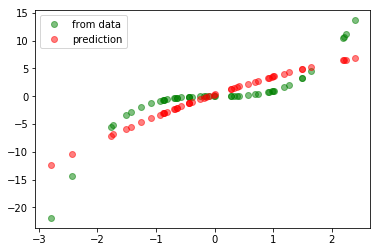

final state
OrderedDict([('linear.weight', tensor([[-3.5764]])), ('quadratic.weight', tensor([[[ 0.1767]]]))])


In [6]:

print(list(model.parameters()))

epochs = 50

print('initial state')
print(model.state_dict())

for epoch in range(epochs):
    epoch +=1 #increase the number of epochs by 1 every time
    inputs = Variable(torch.from_numpy(x_training))#converts the input data from numpy to a tensor
    target = Variable(torch.from_numpy(y_training))#converts the true y from numpy to a tensor
    
    #clear grads
    optimiser.zero_grad()
    #forward to get predicted values
    outputs = model.forward(inputs)#values predicted by the model
    params = list(model.parameters())#learnable parameters of the model
    loss = criterion.forward(inputs, target, params)#model.parameters() 
    loss.backward()# back props
    optimiser.step()# update the parameters
    
    if epoch%10 == 0:
        print('epoch {}, loss {}'.format(epoch,loss.item()))
        print(list(model.parameters()))
    

def Predict(inputs, model):
    ## evaluates Lu
    n = inputs.size()[0]
    predicted = np.zeros(n)
    for i in range(n):  
        predicted[i] = stein_operator(inputs[i], list(model.parameters()))
    return(predicted)

predicted = Predict(inputs, model)

#model.forward(Variable(torch.from_numpy(x_training))).data.numpy()

plt.plot(x_training, y_training, 'go', label = 'from data', alpha = .5)
plt.plot(x_training, predicted,'go', color="red", label = 'prediction', alpha = 0.5)
plt.legend()
plt.show()
print('final state')
print(model.state_dict())